In [ ]:
!pip install --upgrade --quiet phiflow==3.4

In [6]:
from phi.tf.flow import *
import pylab as plt


In [3]:
N = 128
DX = 2/N
STEPS = 32
DT = 1/STEPS
NU = 0.01/(N*np.pi)

# allocate velocity grid
velocity = CenteredGrid(0, extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))

# and a grid with the reference solution 
REFERENCE_DATA = math.tensor([0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] , math.spatial('x'))
SOLUTION_T16 = CenteredGrid( REFERENCE_DATA, extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))

In [4]:
type(velocity.values.native())

tensorflow.python.framework.ops.EagerTensor

In [5]:
def loss_function(velocity):
    velocities = [velocity]
    for time_step in range(STEPS):
        v1 = diffuse.explicit(1.0*velocities[-1], NU, DT, substeps=1)
        v2 = advect.semi_lagrangian(v1, v1, DT)
        velocities.append(v2)
    loss = field.l2_loss(velocities[16] - SOLUTION_T16)*2./N # MSE
    return loss, velocities

gradient_function = math.gradient(loss_function)

(loss,velocities), grad = gradient_function(velocity)

print('Loss: %f' % (loss))

Loss: 0.382915


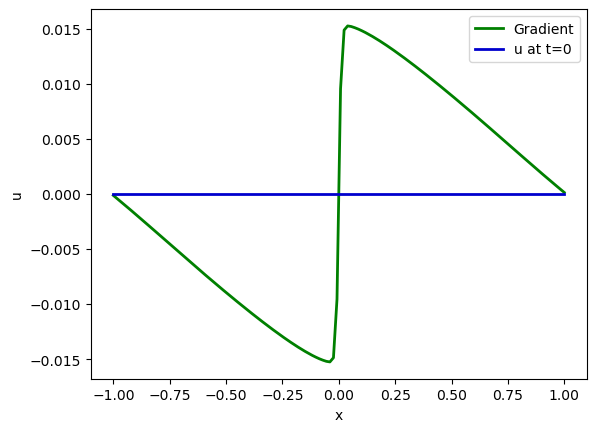

In [7]:
fig = plt.figure().gca()
pltx = np.linspace(-1,1,N)

# first gradient
fig.plot(pltx, grad[0].values.numpy('x')           , lw=2, color='green',      label="Gradient")  
fig.plot(pltx, velocity.values.numpy('x'), lw=2, color='mediumblue', label="u at t=0")
plt.xlabel('x'); plt.ylabel('u'); plt.legend();

# some (optional) other fields to plot:
# fig.plot(pltx,  (velocities[16]).values.numpy('x')   , lw=2, color='cyan', label="u at t=0.5")  
# fig.plot(pltx,  (SOLUTION_T16).values.numpy('x')   , lw=2, color='red', label="solution at t=0.5")  
# fig.plot(pltx,  (velocities[16] - SOLUTION_T16).values.numpy('x')   , lw=2, color='blue', label="difference at t=0.5")  

In [8]:
LR = 5.

grads=[]
for optim_step in range(5):
    (loss,velocities), grad = gradient_function(velocity)
    print('Optimization step %d, loss: %f' % (optim_step,loss))
    grads.append( grad[0] )

    velocity = velocity - LR * grads[-1]

Optimization step 0, loss: 0.382915
Optimization step 1, loss: 0.326882
Optimization step 2, loss: 0.281032
Optimization step 3, loss: 0.242804
Optimization step 4, loss: 0.210666


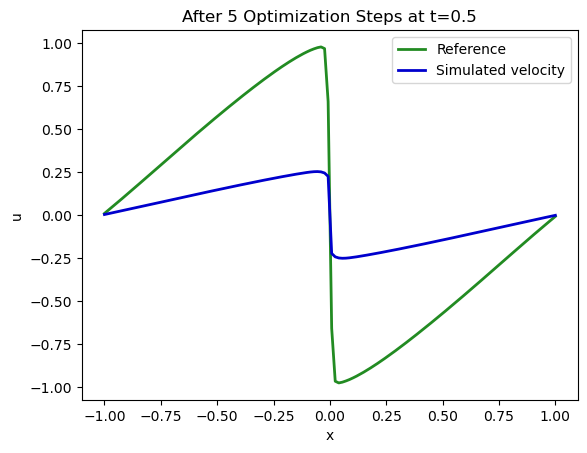

In [9]:
fig = plt.figure().gca()

# target constraint at t=0.5
fig.plot(pltx, SOLUTION_T16.values.numpy('x'), lw=2, color='forestgreen',  label="Reference") 

# optimized state of our simulation after 16 steps
fig.plot(pltx, velocities[16].values.numpy('x'), lw=2, color='mediumblue', label="Simulated velocity")

plt.xlabel('x'); plt.ylabel('u'); plt.legend(); plt.title("After 5 Optimization Steps at t=0.5");

In [10]:
import time
start = time.time()

for optim_step in range(5,50):
    (loss,velocities), grad = gradient_function(velocity)
    velocity = velocity - LR * grad[0]
    if optim_step%5==0: 
      print('Optimization step %d, loss: %f' % (optim_step,loss))

end = time.time()
print("Runtime {:.2f}s".format(end-start))

Optimization step 5, loss: 0.183476
Optimization step 10, loss: 0.096224
Optimization step 15, loss: 0.054792
Optimization step 20, loss: 0.032819
Optimization step 25, loss: 0.020334
Optimization step 30, loss: 0.012852
Optimization step 35, loss: 0.008185
Optimization step 40, loss: 0.005186
Optimization step 45, loss: 0.003263
Runtime 40.31s


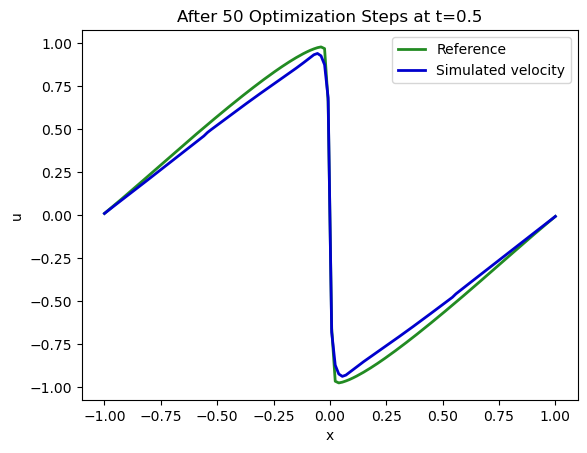

In [11]:
fig = plt.figure().gca()
fig.plot(pltx, SOLUTION_T16.values.numpy('x'), lw=2, color='forestgreen',  label="Reference") 
fig.plot(pltx, velocities[16].values.numpy('x'), lw=2, color='mediumblue', label="Simulated velocity")
plt.xlabel('x'); plt.ylabel('u'); plt.legend(); plt.title("After 50 Optimization Steps at t=0.5");

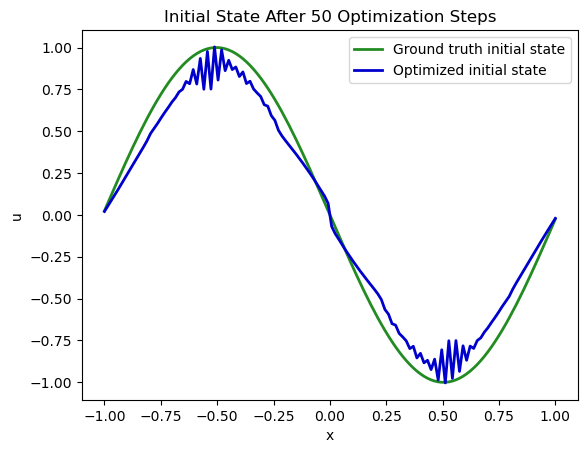

In [12]:
fig = plt.figure().gca()
pltx = np.linspace(-1,1,N)

# ground truth state at time=0 , move down
INITIAL_GT = np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ) # 1D numpy array
fig.plot(pltx, INITIAL_GT.flatten()      , lw=2, color='forestgreen', label="Ground truth initial state")  # ground truth initial state of sim
fig.plot(pltx, velocity.values.numpy('x'), lw=2, color='mediumblue',  label="Optimized initial state") # manual
plt.xlabel('x'); plt.ylabel('u'); plt.legend(); plt.title("Initial State After 50 Optimization Steps");

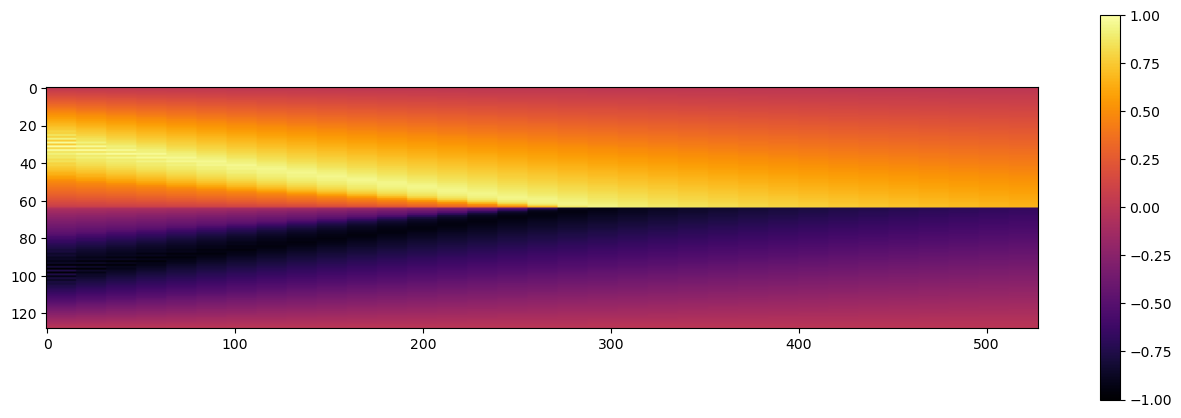

In [13]:
import pylab

def show_state(a):
    a=np.expand_dims(a, axis=2)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=2)
    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    pylab.colorbar(im) 
        
# get numpy versions of all states 
vels = [ x.values.numpy('x,vector') for x in velocities] 
# concatenate along vector/features dimension
vels = np.concatenate(vels, axis=-1) 

# save for comparison with other methods
# import os; os.makedirs("./temp",exist_ok=True)
# np.savez_compressed("./temp/burgers-diffphys-solution.npz", np.reshape(vels,[N,STEPS+1])) # remove batch & channel dimension

show_state(vels)

In [ ]:
# CELL NOT WORKING FOR NOW - TO COMPARE THE 3 METHODS SIDE BY SIDE

# note, this requires previous runs of the forward-sim & PINN notebooks in the same environment
# sol_gt=npfile=np.load("./temp/burgers-groundtruth-solution.npz")["arr_0"] 
# sol_pi=npfile=np.load("./temp/burgers-pinn-solution.npz")["arr_0"] 
# sol_dp=npfile=np.load("./temp/burgers-diffphys-solution.npz")["arr_0"] 

# divider = np.ones([10,33])*-1. # we'll sneak in a block of -1s to show a black divider in the image
# sbs = np.concatenate( [sol_gt, divider, sol_pi, divider, sol_dp], axis=0)

# print("\nSolutions Ground Truth (top), PINN (middle) , DiffPhys (bottom):")
# show_state(np.reshape(sbs,[N*3+20,33,1]))

In [15]:
# SAME HERE

# err_pi = np.sum( np.abs(sol_pi-sol_gt)) / (STEPS*N)
# err_dp = np.sum( np.abs(sol_dp-sol_gt)) / (STEPS*N)
# print("MAE PINN: {:7.5f} \nMAE DP:   {:7.5f}".format(err_pi,err_dp))

# print("\nError GT to PINN (top) , GT to DiffPhys (bottom):")
# show_state(np.reshape( np.concatenate([sol_pi-sol_gt, divider, sol_dp-sol_gt],axis=0) ,[N*2+10,33,1]))